Country-level data for clustering analysis:
     country  total_renewable_capacity  total_capacity   energy_use           gdp  env_tax  renewable_ratio
0    albania                   1431.00        1529.000   719.584378  8.052077e+09     0.43         0.935906
1    albania                   1431.00        1529.000   719.584378  8.052077e+09     2.37         0.935906
2  argentina                  10727.09       32913.079  1706.464137  1.987371e+11     5.31         0.325922
3  argentina                  10727.09       32913.079  1706.464137  1.987371e+11     1.30         0.325922
6  australia                  19009.10       65852.016  5624.192019  6.956929e+11     7.24         0.288664


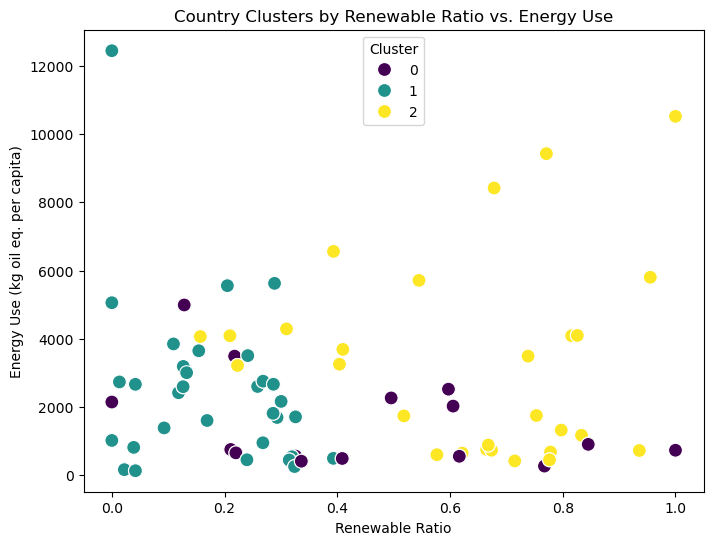

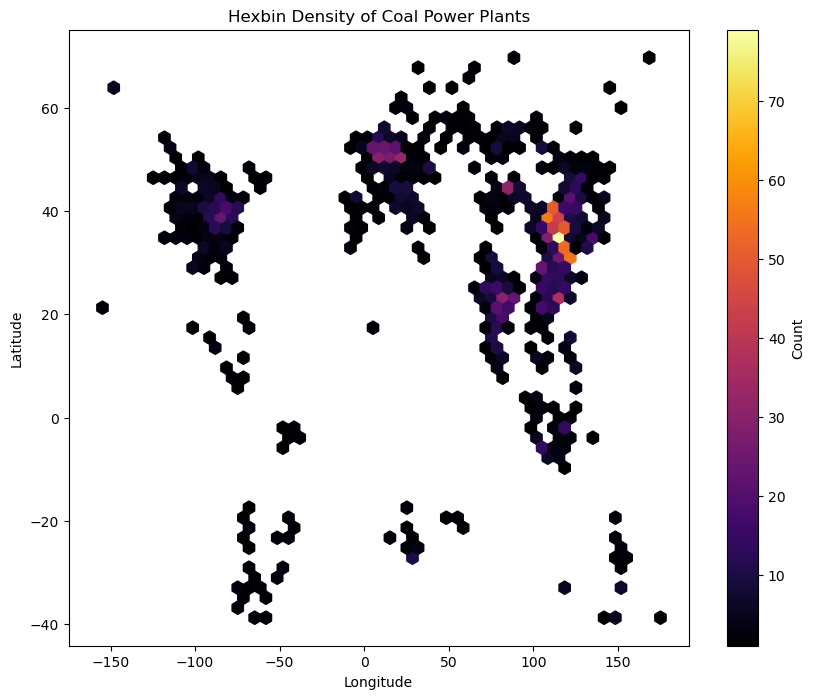

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Set pandas options to display full output if needed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# ---------------------------------------------------
# PART 1: Clustering Analysis of Countries
# ---------------------------------------------------

# Connect to the SQLite database
conn = sqlite3.connect("global_energy.db")

# Load country capacity data from table 'country_capacity'
# If the table doesn't exist, compute it from the power_plants table.
try:
    df_country_capacity = pd.read_sql_query("SELECT * FROM country_capacity;", conn)
except Exception as e:
    print("country_capacity table not found. Computing aggregated data from power_plants.")
    df_power = pd.read_sql_query("SELECT country, primary_fuel, capacity_mw FROM power_plants;", conn)
    # Define renewable fuel types (using lowercase for matching)
    renewable_fuels = ['solar', 'wind', 'hydro']
    df_power['is_renewable'] = df_power['primary_fuel'].str.lower().apply(lambda x: 1 if x in renewable_fuels else 0)
    df_country_capacity = df_power.groupby('country').agg(
        total_capacity=('capacity_mw', 'sum'),
        total_renewable_capacity=('capacity_mw', lambda x: x[df_power.loc[x.index, 'is_renewable'] == 1].sum())
    ).reset_index()
    df_country_capacity.to_sql("country_capacity", conn, if_exists="replace", index=False)

# Query World Bank indicators for a chosen year (2005)
chosen_year = 2005
indicator_energy = "Energy use (kg of oil equivalent per capita)"
indicator_gdp = "GDP (current US$)"

df_energy = pd.read_sql_query(f"""
SELECT country, "{chosen_year} [YR{chosen_year}]" AS energy_use
FROM world_bank
WHERE [Series Name] = '{indicator_energy}'
""", conn)

df_gdp = pd.read_sql_query(f"""
SELECT country, "{chosen_year} [YR{chosen_year}]" AS gdp
FROM world_bank
WHERE [Series Name] = '{indicator_gdp}'
""", conn)

# Query OECD greengrowth table for the environmental tax indicator using measure ENVTAX
df_env_tax = pd.read_sql_query(f"""
SELECT country, OBS_VALUE AS env_tax
FROM oecd_greengrowth
WHERE MEASURE = 'ENVTAX' AND TIME_PERIOD = '{chosen_year}'
""", conn)

conn.close()

# Standardize country names in all DataFrames (convert to lowercase and strip spaces)
for df in [df_country_capacity, df_energy, df_gdp, df_env_tax]:
    df['country'] = df['country'].str.lower().str.strip()

# Merge datasets on the 'country' column
df_country = pd.merge(df_country_capacity, df_energy, on="country", how="inner")
df_country = pd.merge(df_country, df_gdp, on="country", how="inner")
df_country = pd.merge(df_country, df_env_tax, on="country", how="inner")

# Compute the renewable capacity ratio
df_country['renewable_ratio'] = df_country['total_renewable_capacity'] / df_country['total_capacity']

# Convert key columns to numeric and drop rows with missing values
df_country['energy_use'] = pd.to_numeric(df_country['energy_use'], errors='coerce')
df_country['gdp'] = pd.to_numeric(df_country['gdp'], errors='coerce')
df_country['env_tax'] = pd.to_numeric(df_country['env_tax'], errors='coerce')
df_country.dropna(subset=['renewable_ratio', 'energy_use', 'gdp', 'env_tax'], inplace=True)

print("Country-level data for clustering analysis:")
print(df_country.head())

if df_country.empty:
    raise ValueError("No overlapping country data found. Check your data sources and country names.")

# Select features for clustering
features = ['renewable_ratio', 'energy_use', 'gdp', 'env_tax']
X = df_country[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run K-Means clustering (using 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
df_country['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters with a scatter plot (renewable_ratio vs. energy_use)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_country, x='renewable_ratio', y='energy_use', hue='cluster', palette='viridis', s=100)
plt.title('Country Clusters by Renewable Ratio vs. Energy Use')
plt.xlabel('Renewable Ratio')
plt.ylabel('Energy Use (kg oil eq. per capita)')
plt.legend(title='Cluster')
plt.show()

# ---------------------------------------------------
# PART 2: Geospatial Hotspot Analysis of Power Plants
# ---------------------------------------------------

# Reconnect to the database and load power plant data
conn = sqlite3.connect("global_energy.db")
df_plants = pd.read_sql_query("SELECT * FROM power_plants", conn)
conn.close()

# Create a GeoDataFrame using geopandas (using longitude and latitude)
gdf_plants = gpd.GeoDataFrame(
    df_plants,
    geometry=gpd.points_from_xy(df_plants.longitude, df_plants.latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Filter for a specific fuel type (e.g., 'coal') with case-insensitive comparison
fuel_type = 'coal'
gdf_fuel = gdf_plants[gdf_plants['primary_fuel'].str.lower() == fuel_type]

# Plot a hexbin density map for the selected fuel type
plt.figure(figsize=(10,8))
plt.hexbin(gdf_fuel.geometry.x, gdf_fuel.geometry.y, gridsize=50, cmap='inferno', mincnt=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Hexbin Density of {fuel_type.capitalize()} Power Plants')
cb = plt.colorbar()
cb.set_label('Count')
plt.show()

In [2]:
import sqlite3
import pandas as pd

# Set Pandas options to display all rows and full width
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

conn = sqlite3.connect("global_energy.db")
df_measures = pd.read_sql_query("SELECT DISTINCT MEASURE FROM oecd_greengrowth", conn)
print("Available OECD Measures:")
print(df_measures)
conn.close()

Available OECD Measures:
               MEASURE
0          WATER_FWCAP
1              PBAL_HA
2            FIT_SOLAR
3            SANI_SPOP
4        SW_SEASTOPERM
5           EPRICE_IND
6             DMC_PROD
7               GDP_PC
8                  DEF
9               ENVQOL
10           PM_SPEX10
11          SW_PERMWAT
12             DMC_MIN
13      PA_TERRESTRIAL
14         POP_NETMIGR
15              PB_MOR
16             RE_TPES
17              ODA_RE
18           FOR_STOCK
19                 NRG
20            GHG_PBEM
21                 FOR
22              ENVTAX
23                NRGC
24               WATER
25        EAMFP_EAMFPG
26              PM_MOR
27               RN_SC
28            WATER_FW
29              ECOPOL
30          ENVRESPROD
31            CO2_PBEM
32              SOCECO
33                RENV
34          POP_Y15T64
35         GHG_DBEMCAP
36             ODA_DES
37             FOR_NAT
38                 CSE
39                 GHG
40        IRRIG_AGLAND
41       